## groups separated GMs

* original fit N-10
* aligned group-1 manual (informed by covariance)
* aligned group-1 with procrust (ref=group-0 original)

* Old group separate, aligend to av-risk-Margulies, but only N-3


In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 

import nilearn.plotting as nplt
import matplotlib.pyplot as plt
from  nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage() # default 5


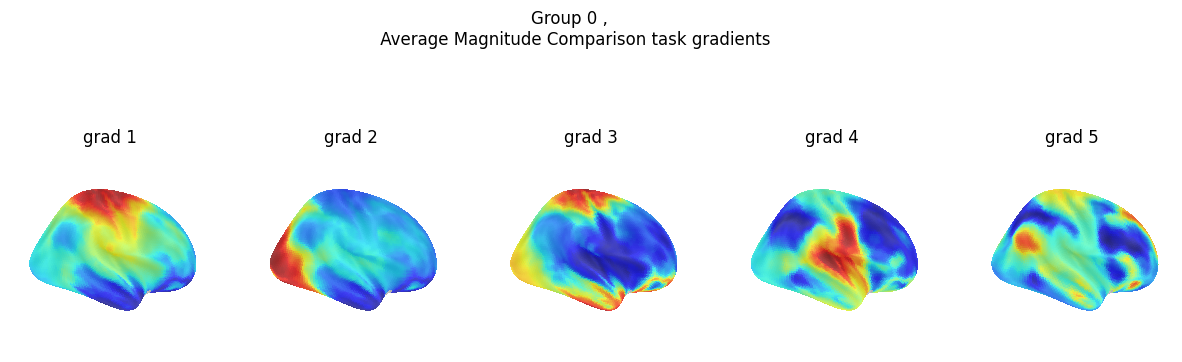

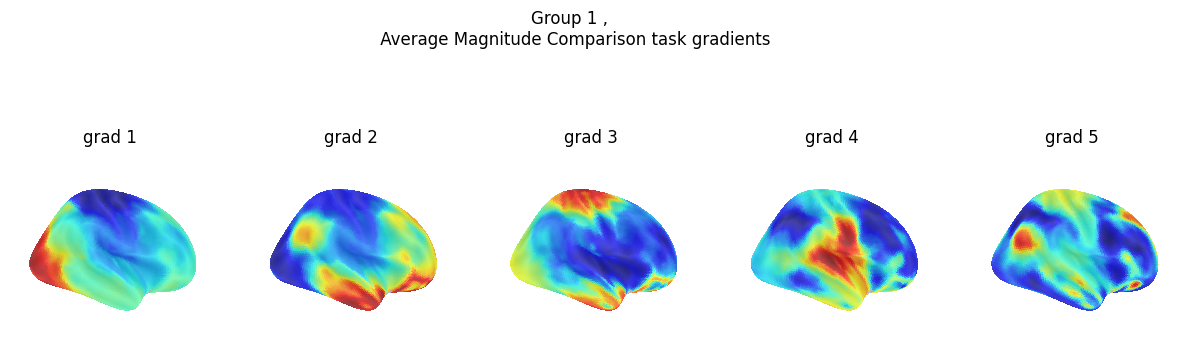

In [ ]:
# Original fit 

 
n_comp = 5
side_view = 'medial'
cmap = 'jet'

for group in range(2):
    sub = group
    target_dir = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    grad = np.load(op.join(target_dir,f'sub-{sub}_gradients_N-10.npy'))

    figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,4), subplot_kw=dict(projection='3d'))
    for i in range(0,n_comp):
        gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
        gm_r = gm[1]

        nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                    view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                    bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7 ,axes=axes[i]) #
        axes[i].set(title=f'grad {i+1}')
    figure.suptitle(f'Group {sub} , \n Average Magnitude Comparison task gradients', y=1.1)


### Align manually (visually but test formally with covariance)

In [62]:
grad_g0 = np.load(op.join(bids_folder,'derivatives', 'gradients', f'sub-0', f'sub-0_gradients_N-10.npy'))[:5,:]
grad_g1 = np.load(op.join(bids_folder,'derivatives', 'gradients', f'sub-1', f'sub-1_gradients_N-10.npy'))[:5,:]


from numrisk.fmri_analysis.gradients.utils import get_basic_mask
import matplotlib.pyplot as plt

mask, _ = get_basic_mask()
if np.any((np.isnan(grad_g0[:,mask]))):
    mask[np.isnan(grad_g0[0,])] = False
if np.any((np.isnan(grad_g1[:,mask]))):
    mask[np.isnan(grad_g1[0,])] = False

Text(45.722222222222214, 0.5, 'Group 1 (dyscalc)')

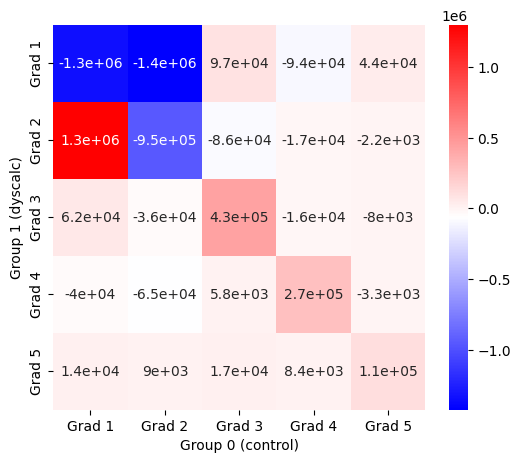

In [63]:
cov = grad_g0[:,mask].dot(grad_g1[:,mask].T)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cov, annot=True, cmap='bwr',# fmt=".2f", 
            xticklabels=[f'Grad {i+1}' for i in range(5)],
            yticklabels=[f'Grad {i+1}' for i in range(5)])
plt.xlabel("Group 0 (control)")
plt.ylabel("Group 1 (dyscalc)")

Text(0.5, 0.9, 'Group 1 man-aligend (first GMs swapped and *-1)')

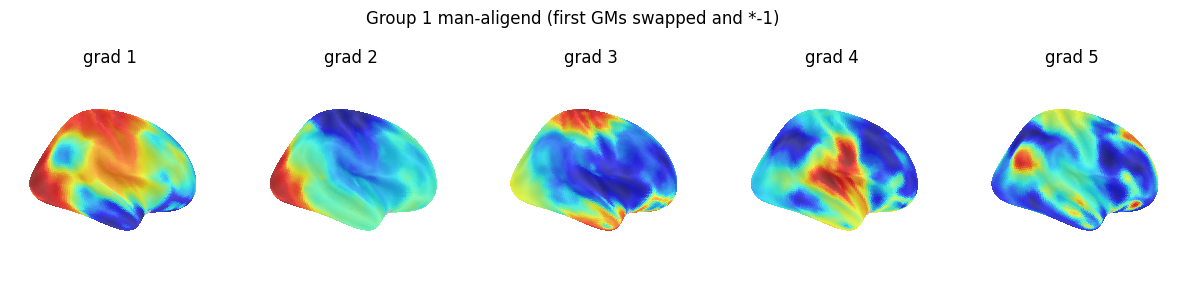

In [61]:
grad_g1 = np.load(op.join(bids_folder,'derivatives', 'gradients', f'sub-1', f'sub-1_gradients_N-10.npy'))[:5,:]
grad_g1_aligned = np.array([-grad_g1[1,:], grad_g1[0,:], grad_g1[2,:], grad_g1[3,:], grad_g1[4,:]])

grad = grad_g1_aligned
figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,4), subplot_kw=dict(projection='3d'))
for i in range(0,n_comp):
    gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_r = gm[1]
    nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7 ,axes=axes[i]) #
    axes[i].set(title=f'grad {i+1}')  

figure.suptitle(f'Group 1 man-aligend (first GMs swapped and *-1)', y=0.9)

### Align with procrust to other groups GMs

In [57]:
# fit group 1 aligend to group 0 
source_folder = op.join(bids_folder,'derivatives','correlation_matrices')
cm = np.load(op.join(source_folder,f'cm_av_group-{group}.npy'))

grad_g0 = np.load(op.join(bids_folder,'derivatives', 'gradients', f'sub-0', f'sub-0_gms_N-10.npy'))

from brainspace.gradient import GradientMaps
gm = GradientMaps(n_components=10,alignment='procrustes') # defaults: approacch = 'dm', kernel = None
gm.fit(cm,reference=grad_g0)
print(f'finished sub-{sub}: gradients generated')

specification = '_aligned-g0'

mask, labeling_noParcel = get_basic_mask()
from brainspace.utils.parcellation import map_to_labels

grad = [None] * 10

for i, g in enumerate(gm.aligned_.T): # 
    grad[i] = map_to_labels(g, labeling_noParcel, mask=mask, fill=np.nan)

np.save(op.join(target_dir,f'sub-{sub}_gradients{specification}_N-10.npy'), grad) # for plotting
np.save(op.join(target_dir,f'sub-{sub}_gms{specification}_N-10.npy'), gm.aligned_) # for alignment reference! 
np.save(op.join(target_dir,f'sub-{sub}_lambdas{specification}_N-10.npy'), gm.lambdas_) 

/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


finished sub-1: gradients generated


Text(0.5, 0.9, 'Group 1 aligned to group-0 GMs')

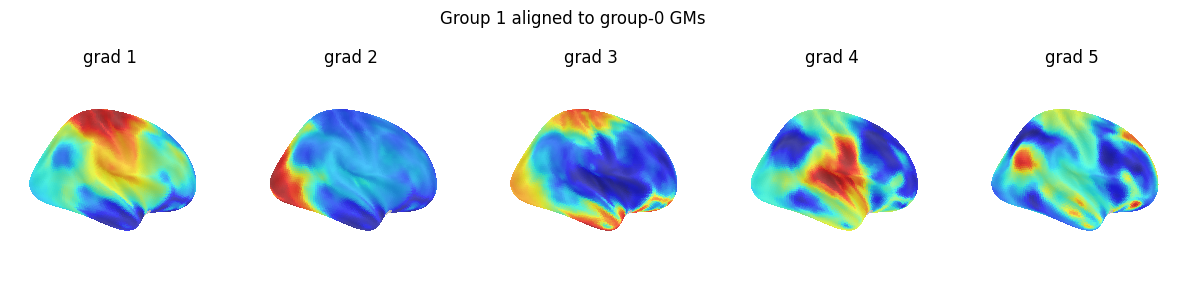

In [59]:
specification = '_aligned-g0'
sub = 1
target_dir = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
grad = np.load(op.join(target_dir,f'sub-{sub}_gradients{specification}_N-10.npy'))

figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,4), subplot_kw=dict(projection='3d'))
for i in range(0,n_comp):
    gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_r = gm[1]

    nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7 ,axes=axes[i]) #
    axes[i].set(title=f'grad {i+1}')
figure.suptitle(f'Group 1 aligned to group-0 GMs', y=0.9)

## Network dispersions along GMs

In [2]:
from utils import get_glasser_parcels, get_glasser_CAatlas_mapping
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()

labeling_glasser_orig = [int(str(label)[1:]) for label in labeling_glasser] # [mask_glasser]

#CAatlas_fsav5 = [glasser_CAatlas_mapping.loc[labeling_glasser_orig[i]]['ca_network'] for i in labeling_glasser_orig]
# Same: 
from brainspace.utils.parcellation import map_to_labels
CAatlas_fsav5 = map_to_labels(glasser_CAatlas_mapping['ca_network'].values , labeling_glasser, mask=mask_glasser) #, fill=np.nan) #grad_sub[n_grad-1]

import hcp_utils as hcp
from matplotlib.colors import ListedColormap
import seaborn as sns
rgb = np.array(list(hcp.ca_network['rgba'].values())[1:])
ca_cmap = ListedColormap(np.vstack(([1, 1, 1, 1], rgb)), 'custom_colormap') # add white infront, 0=unknown, 1-12 actual labels


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
n_grad = 1
specification = '_aligned-g0'
grad_g1a = np.load(op.join(bids_folder, 'derivatives', 'gradients', f'sub-1',f'sub-1_gradients{specification}_N-10.npy'))
grad_g0r = np.load(op.join(bids_folder, 'derivatives', 'gradients', f'sub-0',f'sub-0_gradients_N-10.npy'))
grads = np.array([grad_g0r[n_grad-1,:], grad_g1a[n_grad-1,:],CAatlas_fsav5])

df = pd.DataFrame(grads.T, columns =['control','dyscalc','ca_network' ]) 


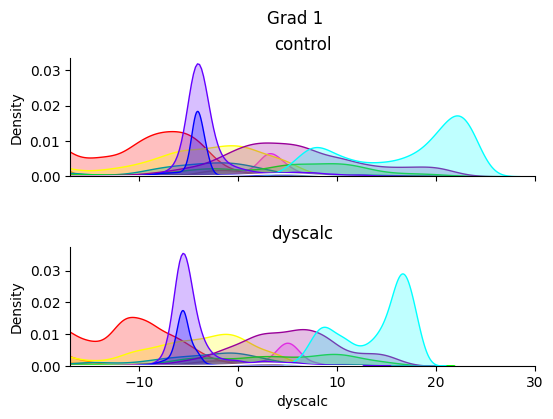

In [4]:
import hcp_utils as hcp
from matplotlib.colors import ListedColormap
import seaborn as sns
rgb = np.array(list(hcp.ca_network['rgba'].values())[1:])
ca_cmap = ListedColormap(np.vstack(([1, 1, 1, 1], rgb)), 'custom_colormap') # add white infront, 0=unknown, 1-12 actual labels

fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
sns.kdeplot(df,hue='ca_network',x='control',fill=True,palette=ca_cmap, ax=axs[0],legend=False )
sns.kdeplot(df,hue='ca_network',x='dyscalc',fill=True,palette=ca_cmap, ax=axs[1],legend=False )
fig.subplots_adjust(hspace=0.6)
axs[0].set(title='control', xlim=(-17,30))
axs[1].set(title='dyscalc', xlim=(-17,30))
fig.suptitle(f'Grad {n_grad}',y=1)

sns.despine()


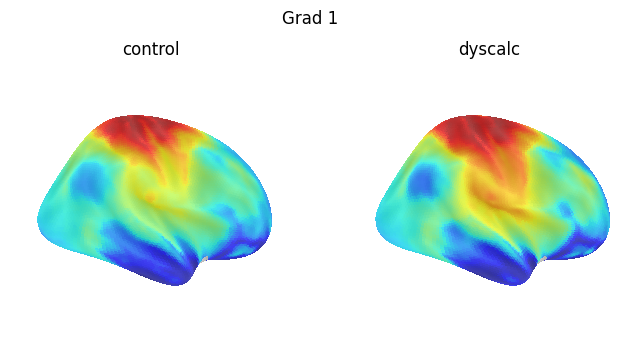

In [5]:
figure, axes = plt.subplots(nrows=1, ncols=2,figsize = (8,4), subplot_kw=dict(projection='3d'))
view = 'medial'
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= np.split(grad_g0r[n_grad-1,:],2)[1],
            view= view,cmap='jet', colorbar=False, title=f'control',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7, axes=axes[0]) #
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= np.split(grad_g1a[n_grad-1,:],2)[1],
            view= view,cmap='jet', colorbar=False, title=f'dyscalc',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7, axes=axes[1]) #
figure.suptitle(f'Grad {n_grad}')
figure.subplots_adjust(wspace=0.2)


<Axes: xlabel='dyscalc', ylabel='Density'>

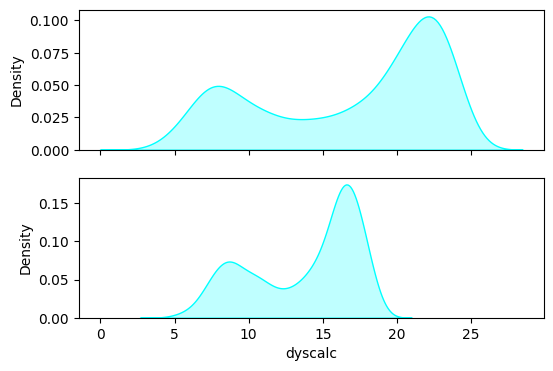

In [6]:
network_label = 3
temp = df[df['ca_network'] == network_label]
fig, axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
sns.kdeplot(temp,x='control',fill=True,color=rgb[int(network_label-1)], ax=axs[0],legend=False )
sns.kdeplot(temp,x='dyscalc',fill=True,color=rgb[int(network_label-1)], ax=axs[1],legend=False )


maybe the result of the alignment? as for dyscalcs, the motor cortex was originally not the anchor?!

In [7]:
specification = '_aligned-g0'
grad_g1a = np.load(op.join(bids_folder, 'derivatives', 'gradients', f'sub-1',f'sub-1_gradients{specification}_N-10.npy'))
grad_g0r = np.load(op.join(bids_folder, 'derivatives', 'gradients', f'sub-0',f'sub-0_gradients_N-10.npy'))
grads = np.array([grad_g0r[0,:], grad_g1a[0,:],grad_g0r[1,:], grad_g1a[1,:],CAatlas_fsav5])
df = pd.DataFrame(grads.T, columns =['g1_control','g1_dyscalc','g2_control','g2_dyscalc','ca_network']) 

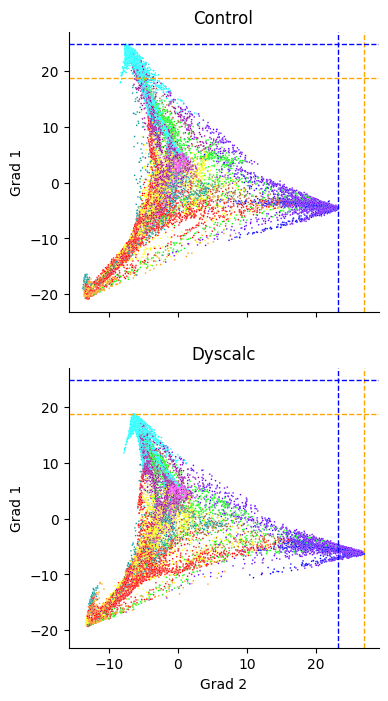

In [20]:
import seaborn as sns

fig, axs = plt.subplots(2,1,figsize=(4,8), sharex=True, sharey=True)

sns.scatterplot(df, x='g2_control', y='g1_control', hue='ca_network',palette=ca_cmap,s=1.4, legend=False,ax=axs[0] )
sns.scatterplot(df, x='g2_dyscalc', y='g1_dyscalc', hue='ca_network',palette=ca_cmap,s=1.4, legend=False,ax=axs[1] )
axs[1].set(title='Dyscalc',xlabel='Grad 2',ylabel='Grad 1')
axs[0].set(title='Control',ylabel='Grad 1')

# Add guiding line
for ax in axs:
    ax.axvline(x=df['g2_control'].max(), color='blue', linestyle='--', linewidth=1)
    ax.axvline(x=df['g2_dyscalc'].max(), color='orange', linestyle='--', linewidth=1)
    ax.axhline(y=df['g1_control'].max(), color='blue', linestyle='--', linewidth=1)
    ax.axhline(y=df['g1_dyscalc'].max(), color='orange', linestyle='--', linewidth=1)

sns.despine()

In [14]:
df['g2_control'].max()

23.213729300291803

In [12]:
grad_all = np.load(op.join(bids_folder, 'derivatives', 'gradients', f'sub-All',f'sub-All_gradients_N-10.npy'))


Text(0.5, 0, 'grad 3')

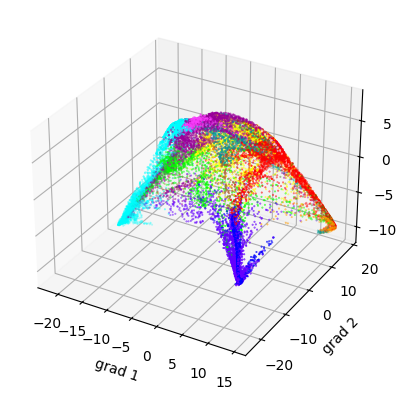

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(-grad_all[0,:], -grad_all[1,:], -grad_all[2,:], cmap=ca_cmap, c=CAatlas_fsav5, s = 0.2)
ax.set_xlabel('grad 1')
ax.set_ylabel('grad 2')
ax.set_zlabel('grad 3')

# movable 3D plot: import plotly.graph_objects as go

# Old/Additional

In [ ]:
# Old group separate, aligend to av-risk-Margulies, but only N-3

n_comp = 3
side_view = 'medial'
cmap = 'viridis'

for group in range(2):
    sub = f'avGroup{group}'
    specification = '-aligned'
    target_dir = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    grad = np.load(op.join(target_dir,f'sub-{sub}_gradients-aligned.npy'))

    figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,4), subplot_kw=dict(projection='3d'))
    for i in range(0,n_comp):
        gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
        gm_r = gm[1]

        nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
                    view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                    bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7 ,axes=axes[i]) #
        axes[i].set(title=f'grad {i+1}')
    figure.suptitle(f'Group {sub} - aligned , \n Average Magnitude Comparison task gradients', y=1.1)
